# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

In [2]:
from sklearn.metrics import confusion_matrix
import itertools



Using TensorFlow backend.


# Data Preparation

### Load data

In [34]:
train = pd.read_csv('./train.csv')

test = pd.read_csv('./test.csv')

In [35]:
train.tail(2)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41999,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [36]:
X = train.drop('label',axis=1)
y = train['label']

del train

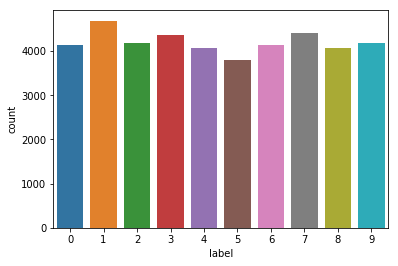

In [37]:
sns.countplot(y)

In [38]:
y.value_counts()

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

### Check for null

In [39]:
X.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [40]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

Don't have missing values in images

# Normalization

In [41]:
X = X/255.0
test = test/255.0

### Reshape

reshape image in 3 dimensions

In [42]:
X.shape

(42000, 784)

In [46]:
X = X.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

# (number img,height = 28px, width = 28px, canal =1)

In [47]:
X.shape

(42000, 28, 28, 1)

#### One - Hot -  Encoding

In [48]:
from keras.utils.np_utils import to_categorical

In [49]:
# convert to one-hot-encoding
y = to_categorical(y)

#### Split Train and Test

In [51]:
from sklearn.model_selection import train_test_split

In [52]:
X_train,X_test,y_train,y_test= train_test_split(
X,
y,
test_size = 0.1,
random_state = 2,
)

### Show image

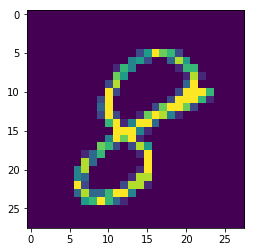

In [53]:
plt.imshow(X_train[0][:,:,0])

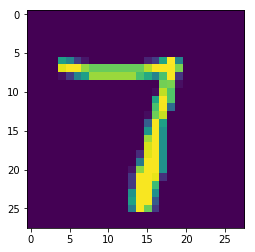

In [54]:
plt.imshow(X_train[1][:,:,0])

# CNN - Convolutional neural network

Resumo:
- Conv2D -> a convolução permite aplicar filtros que ajudam a identificar padrões/características através de MAPAS.
- Maxpool2D-> Praticamente é utilizado para Diminuir o nosso MAPA (reduz a necessidade de poder computacional).
- Flatting -> transforma os inputs de Matriz em Vetores.


The first is the convolutional (Conv2D) layer. It is like a set of learnable filters. I choosed to set 32 filters for the two firsts conv2D layers and 64 filters for the two last ones. Each filter transforms a part of the image (defined by the kernel size) using the kernel filter. The kernel filter matrix is applied on the whole image. Filters can be seen as a transformation of the image.

The CNN can isolate features that are useful everywhere from these transformed images (feature maps).

The second important layer in CNN is the pooling (MaxPool2D) layer. This layer simply acts as a downsampling filter. It looks at the 2 neighboring pixels and picks the maximal value. These are used to reduce computational cost, and to some extent also reduce overfitting. We have to choose the pooling size (i.e the area size pooled each time) more the pooling dimension is high, more the downsampling is important.

Combining convolutional and pooling layers, CNN are able to combine local features and learn more global features of the image.

Dropout is a regularization method, where a proportion of nodes in the layer are randomly ignored (setting their wieghts to zero) for each training sample. This drops randomly a propotion of the network and forces the network to learn features in a distributed way. This technique also improves generalization and reduces the overfitting.

'relu' is the rectifier (activation function max(0,x). The rectifier activation function is used to add non linearity to the network.

The Flatten layer is use to convert the final feature maps into a one single 1D vector. This flattening step is needed so that you can make use of fully connected layers after some convolutional/maxpool layers. It combines all the found local features of the previous convolutional layers.

In the end i used the features in two fully-connected (Dense) layers which is just artificial an neural networks (ANN) classifier. In the last layer(Dense(10,activation="softmax")) the net outputs distribution of probability of each class.

Baseado: https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6

In [56]:
from keras.models import Sequential
from keras.layers import (
    Dense,
    Dropout,
    Flatten,
    Conv2D,
    MaxPool2D
)

In [61]:
X_train.shape[1:]

(28, 28, 1)

In [62]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu',
                 #input_shape = (28,28,1)
                 input_shape = X_train.shape[1:]# Prefiro usar assim
                )
         )
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

In [63]:
from keras.optimizers import RMSprop

In [64]:
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [66]:
from keras.callbacks import ReduceLROnPlateau

In [65]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [67]:
epochs = 1 # Turn epochs to 30 to get 0.9967 accuracy
batch_size = 86

In [ ]:
# Without data augmentation i obtained an accuracy of 0.98114
#history = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, 
#          validation_data = (X_val, Y_val), verbose = 2)

In [70]:
from keras.preprocessing.image import ImageDataGenerator

In [69]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
)

In [73]:
# Fit the model
history = model.fit_generator(datagen.flow(
    X_train,
    y_train,
    batch_size=batch_size),
                              epochs = epochs,
                              validation_data = (X_test,y_test),
                              verbose = 2,
                              steps_per_epoch=X.shape[0] // batch_size,
                              callbacks=[learning_rate_reduction]
                             )

'# Fit the model\nhistory = model.fit_generator(datagen.flow(\n    X_train,\n    y_train,\n    batch_size=batch_size),\n                              epochs = epochs,\n                              validation_data = (X_test,y_test),\n                              verbose = 2,\n                              steps_per_epoch=X.shape[0] // batch_size,\n                              callbacks=[learning_rate_reduction]\n                             )'

## PLOT

In [ ]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)